# Generate Training Points

# Create LULC training data from existing LULC products.

Key considerations:
* Spatial distribution, especially in SIDS
* Class distribution
* Temporal coverage
* Quality and confidence
* Trends in agreement with LULC datasets

References
- [ ] https://github.com/frontiersi/FAO_LC_workshop_Rwanda/blob/main/0_Generate_Training_Points.ipynb
- [ ] https://github.com/frontiersi/land_cover_mapping_DEAfrica/blob/main/notebooks/Lesotho/Filter_training_data_GEE_replicate.ipynb
- [ ] https://github.com/auspatious/ldn-lulc/blob/main/notebooks/Compare_LULC.ipynb
- [ ] https://github.com/auspatious/ldn-lulc/blob/main/notebooks/Compare_LULC_per_class.ipynb

Steps
1. Extract points with reliable LU/LC classes from existing products. Use these 3 https://github.com/auspatious/ldn-lulc/blob/main/notebooks/Compare_LULC_per_class.ipynb. ESA Worldcover is the best one. Do this for Singaport or Suva, Fiji bounding box (due to presence of all classes hopefully). Classes should have roughly equal proportions in the sample points. Random sample all classes, use cluster method to reject outliers. This tells you which training points are more reliable.
2. Align typologies/classes from those products to our classes defined here (level 1 only) https://github.com/auspatious/ldn-lulc/blob/8dd22d4190207c977c55e4cde9f236df6daf8722/typology/typology.md
3. Extract the observational data (RGB and all other bands incl. geomad attributes), indices (NDVI, etc. TBC), DEM, etc.) This partially relies on geomad.
4. Then iterate and tune the method to extract reliable training data.

Output schema of training data: coordinates, crs, year, class, source of class e.g. "ESA Worldcover", RGB, all other bands, geomad properties, indices (e.g. NDVI), elevation.

Forked from https://github.com/frontiersi/FAO_LC_workshop_Rwanda/blob/main/0_Generate_Training_Points.ipynb and https://github.com/auspatious/ldn-lulc/blob/main/notebooks/Compare_LULC_per_class.ipynb

## Background

**Training data** is the most important part of any supervised machine learning workflow. The quality of the training data has a greater impact on the classification than the algorithm used. Large and accurate training data sets are preferable: increasing the training sample size results in increased classification accuracy ([Maxell et al 2018](https://www.tandfonline.com/doi/full/10.1080/01431161.2018.1433343)).  A review of training data methods in the context of Earth Observation is available [here](https://www.mdpi.com/2072-4292/12/6/1034).

There are many platforms to use for gathering land cover training labels, the best one to use depends on your application. GIS platforms are great for collecting training data as they are highly flexible and mature platforms; [Geo-Wiki](https://www.geo-wiki.org/) and [Collect Earth Online](https://collect.earth/home) are two open-source websites that may also be useful depending on the reference data strategy employed. Alternatively, there are many pre-existing training datasets on the web that may be useful, e.g. [Radiant Earth](https://www.radiant.earth/) manages a growing number of reference datasets for use by anyone. With locations of land cover labels available, we can extract features at these locations from satellite imagery as input for machine learning.  

## Description

As timely training data is not always available, in this notebook we demonstrate how to generate a set of randomly distributed training points for a selected AOI from an existing classification raster.

The workflow includes the following steps:

1. Preview the AOI (Singapore) on a basemap. Define datetime/year of interest.
2. Use existing LU/LC products. 
3. Only use data where they agree. (TODO: resolution 300m?)
4. Remap/merge classes on the classification raster to our typologies.
5. Generate randomly distributed training points and export for future use.
6. Run geomad for AOI and year.
7. Add geomad data to training data points. Export.
8. Add Indices data (TODO: which indices?)
9. Add DEM data.



### Load packages


In [71]:
%matplotlib inline
import warnings
import numpy as np
import geopandas as gpd
import pandas as pd
import xarray as xr
import rioxarray
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap,BoundaryNorm
from matplotlib.patches import Patch
from random_sampling import random_sampling # adapted from function by Chad Burton: https://gist.github.com/cbur24/04760d645aa123a3b1817b07786e7d9f
from datacube.utils.cog import write_cog
from odc.geo import BoundingBox
import yaml


from pystac.client import Client
from pystac import Item
from odc.stac import load
from planetary_computer import sign_url
import rasterio
from scipy.ndimage import uniform_filter

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import sys
import os
sys.path.append(os.path.abspath(".."))
from src.Compare_LULC_func import standardise_class
sys.path.append("../../ldn")
from cli import geomad

In [21]:
# Reload functions during development
%load_ext autoreload
%autoreload 2

In [22]:
datetime = '2020-06'
lulc_class_raster=f'singapore_worldcover_{datetime}_100m.tif'
output_crs='epsg:32648' # WGS84/UTM Zone 48N for Singapore

with open("typology_mapping.yaml") as f:
    typology_mapping = yaml.safe_load(f)

bbox = BoundingBox(
    # TODO: Viti Levu, Fiji
    
    # Singapore
    left=103.6,
    bottom=1.2,
    right=104.1,
    top=1.48,
    crs="EPSG:4326",
)
bbox.explore()

In [23]:
print(typology_mapping.keys())
print(typology_mapping['classes'])
print(typology_mapping['colours'])

world_cover_map = typology_mapping['world_cover_map']
print(type(world_cover_map))
print(world_cover_map)

dict_keys(['classes', 'colours', 'cci_lc_map', 'world_cover_map', 'io_map'])
{'No data': 0, 'Tree': 1, 'Grassland': 2, 'Cropland': 3, 'Wetland': 4, 'Built-up': 5, 'Other land': 6, 'Water': 7}
{0: 'white', 1: 'darkgreen', 2: 'limegreen', 3: 'lime', 4: 'turquoise', 5: 'gray', 6: 'yellow', 7: 'blue'}
<class 'dict'>
{80: 7, 10: 1, 20: 2, 30: 2, 40: 3, 50: 5, 60: 6, 70: 6, 90: 4, 95: 4, 100: 6}


## Use ESA Worldcover as data.
In future combine this with other LU/LC products to check agreement (use https://github.com/auspatious/ldn-lulc/blob/main/notebooks/Compare_LULC_per_class.ipynb)

In [24]:
# Use Planetary Computer STAC API
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1/")

# A generic function to load a product given the boundary
def load_lulc_data(product: str, resolution = 100):
    items = catalog.search(
        collections=[product],
        intersects=bbox.polygon,
        datetime=datetime,
    ).item_collection()

    print(f"Found {len(items)} items for product {product}")

    ds = load(
        items,
        intersects=bbox.polygon,
        crs="EPSG:6933", # TODO: Use output_crs 
        groupby="solar_day",
        resolution=resolution,
        chunks={"x": 2048, "y": 2048},
        patch_url=sign_url,
        resample_alg="nearest",
    )

    print(f"Product {product} has variables: {ds.data_vars}")
    return ds

In [25]:
# TODO: Also add other products to ensure agreement between many products.
# cci_da = load_lulc_data('esa-cci-lc', resolution=300)

# vars = list(cci_da.data_vars)
# cci_da["esa_cci_lc"] = cci_da["lccs_class"]
# ds_tmp = cci_da.drop_vars(vars)
# cci_da = ds_tmp.squeeze().load() # removes any singleton dimension and then load the full data

# # Limit the product within the administrative boundary (mainly for removing the water body)
# region_gdf = gdf.to_crs(epsg=6933)
# data = cci_da.rio.write_crs("EPSG:6933")
# geom = region_gdf.geometry.values
# cci_da = data.rio.clip(geom, region_gdf.crs)

In [26]:
wc_da = load_lulc_data('esa-worldcover', resolution=10)

vars = list(wc_da.data_vars)
wc_da["esa_worldcover"] = wc_da["map"]
ds_tmp = wc_da.drop_vars(vars)
wc_da = ds_tmp.squeeze().load() #removes any singleton dimension and then load the full data

wc_da

# # Reproject WorldCover to match CCI resolution using majority vote
# wc_300m = wc_da.rio.reproject_match(
#     cci_da,
#     resampling=rasterio.enums.Resampling.mode   # majority vote (the value that appears most often)
# )

# Limit the product within the administrative boundary (mainly for removing the water body)
# singapore_polygon_6933 = singapore_polygon.to_crs(epsg=6933)
# data = wc_da.rio.write_crs("EPSG:6933")
# geom = singapore_polygon_6933.geometry.values
# wc_300m = data.rio.clip(geom, singapore_polygon_6933.crs)

Found 1 items for product esa-worldcover
Product esa-worldcover has variables: Data variables:
    map              (time, y, x) uint8 17MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    input_quality.1  (time, y, x) int16 34MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    input_quality.2  (time, y, x) int16 34MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    input_quality.3  (time, y, x) int16 34MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>


<xarray.Dataset> Size: 17MB
Dimensions:         (y: 3572, x: 4826)
Coordinates:
  * y               (y) float64 29kB 1.888e+05 1.888e+05 ... 1.531e+05 1.531e+05
  * x               (x) float64 39kB 9.996e+06 9.996e+06 ... 1.004e+07 1.004e+07
    spatial_ref     int32 4B 6933
    time            datetime64[ns] 8B 2020-01-01
Data variables:
    esa_worldcover  (y, x) uint8 17MB 30 50 40 50 50 50 50 ... 80 80 80 80 80 80

In [27]:
# Standardise the classes to match the typology

# cci_da['esa_cci_lc'] = standardise_class(cci_da['esa_cci_lc'], cci_lc_map)
# wc_300m['esa_worldcover'] = standardise_class(wc_300m['esa_worldcover'], world_cover_map)
# io_300m['io_lulc'] = standardise_class(io_300m['io_lulc'], io_map)
wc_da['esa_worldcover'] = standardise_class(wc_da['esa_worldcover'], world_cover_map)
wc_da


<xarray.Dataset> Size: 17MB
Dimensions:         (y: 3572, x: 4826)
Coordinates:
  * y               (y) float64 29kB 1.888e+05 1.888e+05 ... 1.531e+05 1.531e+05
  * x               (x) float64 39kB 9.996e+06 9.996e+06 ... 1.004e+07 1.004e+07
    spatial_ref     int32 4B 6933
    time            datetime64[ns] 8B 2020-01-01
Data variables:
    esa_worldcover  (y, x) uint8 17MB 2 5 3 5 5 5 5 5 5 5 ... 7 7 7 7 7 7 7 7 7

In [28]:
# Write as tiff.
wc_da.rio.to_raster(lulc_class_raster, dtype='uint8', compress='deflate')

# Read the tiff
classification_map=xr.open_dataset(lulc_class_raster,engine="rasterio").astype(np.uint8)
classification_map=classification_map.to_array().squeeze()
classification_map

<xarray.DataArray (y: 3572, x: 4826)> Size: 17MB
array([[2, 5, 3, ..., 4, 4, 4],
       [2, 5, 5, ..., 4, 1, 1],
       [2, 5, 5, ..., 1, 1, 1],
       ...,
       [7, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 7]], shape=(3572, 4826), dtype=uint8)
Coordinates:
  * y            (y) float64 29kB 1.888e+05 1.888e+05 ... 1.531e+05 1.531e+05
  * x            (x) float64 39kB 9.996e+06 9.996e+06 ... 1.004e+07 1.004e+07
    band         int64 8B 1
    spatial_ref  int64 8B ...
    variable     <U9 36B 'band_data'

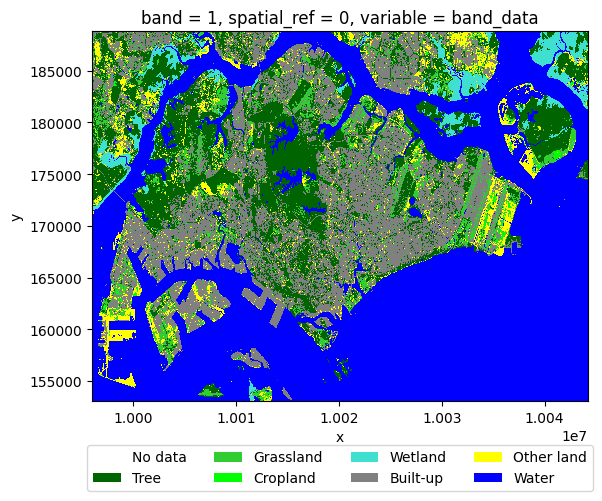

In [29]:
classes = typology_mapping['classes']

colours = typology_mapping['colours']

fig, axes = plt.subplots(1,1)

# Plot classification map
unique_values=np.unique(classification_map)
cmap=ListedColormap([colours[k] for k in unique_values])
norm = BoundaryNorm(list(unique_values)+[np.max(unique_values)+1], cmap.N)
classification_map.plot.imshow(ax=axes, 
                   cmap=cmap,
                   norm=norm,
                   add_labels=True, 
                   add_colorbar=False,
                   interpolation='none')
# add colour legend
patches_list=[Patch(facecolor=colour) for colour in colours.values()]
axes.legend(patches_list, list(classes.keys()),loc='upper center', ncol =4, bbox_to_anchor=(0.5, -0.1))

## Generate random training samples
We generate some randomly distributed samples for each class from the clipped classification map using the `random_sampling` function. This function takes in a few parameters:  
* `da`: a classified map in the format of 2-dimensional xarray.DataArray
* `n`: total number of points to sample.
* `min_sample_n`: Minimum number of samples to generate per class if proportional number is smaller than this. **Note that the resultant number of samples may be higher than the set `n` due to setting of this minimum number of samples.** 
* `sampling`: the sampling strategy, e.g. 'stratified_random' where each class has a number of points proportional to its relative area, 'equal_stratified_random' where each class has the same number of points, or 'manual' which allows you to define number of samples for each class.
* `out_fname`: a filepath name for the function to export a shapefile/geojson of the sampling points into a file. You can set this to `None` if you don't need to output the file.
* `class_attr`: This is the column name of output dataframe that contains the integer class values on the classified map. 
* `drop_value`: pixel value on the classification map to be excluded from sampling.

The output of the function is a geopandas dataframe of randomly distributed points containing a column `class_attr` identifying class values. 

Here we extract around 1000 training points in total and export the points in a geojson file for use in the rest of workflow. Here we use the stratified sampling method by setting 'equal_stratified_random', but also set the minimum number of samples as 3 to avoid missing samples for some minor classes. 

As mentioned earlier we don't want the abandoned classes to be included in the samples we set drop_value as 0 before implementing the function:

In [30]:
# Reproject to WGS84 so sample points are in lat/lon
classification_map_4326 = classification_map.rio.reproject("EPSG:4326")

In [48]:
class_attr='LC_Class_I'
out_fname='training_data.geojson'
n=1000
min_sample_n=75
# # Low numbers for debugging
# n=10
# min_sample_n=1
drop_value=0
gpd_random_samples=random_sampling(da=classification_map_4326,n=n,sampling='stratified_random',
                                   min_sample_n=min_sample_n,out_fname=out_fname,class_attr=class_attr,drop_value=drop_value)

Class 7: sampling at 464locations
Class 5: sampling at 212locations
Class 1: sampling at 186locations
Class 2: sampling at 75locations
Class 6: sampling at 75locations
Class 4: sampling at 75locations
Class 3: sampling at 75locations


In [49]:
print(f"CRS: {gpd_random_samples.crs}")
gpd_random_samples.head()

CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


band   variable  spatial_ref  LC_Class_I                   geometry
0     1  band_data         4326           7  POINT (103.60129 1.29303)
1     1  band_data         4326           7  POINT (103.91532 1.22304)
2     1  band_data         4326           7  POINT (104.04039 1.20519)
3     1  band_data         4326           7  POINT (104.08431 1.36492)
4     1  band_data         4326           7   POINT (104.08965 1.3378)

## Visualise the training data by class

In [ ]:
gpd_random_samples.explore(
    column="LC_Class_I",
    categorical=True,
    categories=(present_classes := sorted(gpd_random_samples["LC_Class_I"].unique())),
    cmap=[colours[c] for c in present_classes],
    legend=True,
    style_kwds={"radius": 6, "fillOpacity": 0.8, "weight": 0.5}
)

In [62]:
# Run geomad for Singapore. It has 2 tiles.
singapore_tile_ids = ["333_112", "333_113"]

# PUT not working at end of geomad so I just used make commands

# from odc.stac import configure_s3_access, configure_rio

# # TODO: Remove these hardcoded secrets before committing
# # Set AWS credentials
# os.environ["AWS_ACCESS_KEY_ID"] = ""
# os.environ["AWS_SECRET_ACCESS_KEY"] = ""
# os.environ["AWS_SESSION_TOKEN"] = ""

# os.environ["AWS_REQUEST_PAYER"] = "requester"
# print("AWS_REQUEST_PAYER:", os.environ.get("AWS_REQUEST_PAYER"))

# # Make sure we can access S3
# _ = configure_s3_access(cloud_defaults=True, requester_pays=True, aws_unsigned=False)

# configure_rio(
#     cloud_defaults=True,
#     # aws={"aws_unsigned": True, "aws_request_payer": "requester"},
# )

# for tile_id in singapore_tile_ids:
#     geomad(
#         tile_id=tile_id,
#         year=datetime.split("-")[0],
#         version="0.0.0",
#         overwrite=True,
#         decimated=True,
#         all_bands=False,
#         region="non-pacific"
#     )

# make geomad-non-pacific-test-singapore-1
# make geomad-non-pacific-test-singapore-2


2026-02-18 14:47:16 | INFO | credentials | botocore.credentials:load:1252 - Found credentials in environment variables.


AWS_REQUEST_PAYER: requester
Running GeoMAD processing for tile 333_112, year 2020, version 0.0.0, region non-pacific with overwrite=True, decimated=True, all_bands=False, memory_limit=10GB, n_workers=2, threads_per_worker=16, xy_chunk_size=2048, geomad_threads=10
Warning, using decimated bands for testing purposes.


2026-02-18 14:47:16 | INFO | credentials | botocore.credentials:load:1252 - Found credentials in environment variables.


Searching for items for area GeoBox((300, 300), Affine(300.0, 0.0, 9970000.0,
       0.0, -300.0, 170000.0), CRS('EPSG:6933'))
Found 119 items for area
78


/Users/wj/Library/Caches/pypoetry/virtualenvs/ldn-TK5rT0MB-py3.12/lib/python3.12/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/Users/wj/Library/Caches/pypoetry/virtualenvs/ldn-TK5rT0MB-py3.12/lib/python3.12/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
2026-02-18 14:48:17,722 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 8211db416c6b5a0c919f424884194e16 initialized by task ('rechunk-merge-rechunk-transfer-d8951d434f74d70095406a548fc24cfb', 0, 0, 0, 0, 0, 0) executed on worker tcp://127.0.0.1:52595
2026-02-18 14:48:21,048 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 8211db416c6b5a0c919f424884194e16 deactivated due to stimulus 'task-finished-1771386501.0469398'
2026-02-18 14:48:32,968 - distributed.shuffle._scheduler_plugin - 

Failed to process with error: An error occurred (InvalidToken) when calling the PutObject operation: The provided token is malformed or otherwise invalid.


Exit: 

In [ ]:
# TODO: Use the AOI bbox to decide where to sample the geomad data from instead of hardcoding the tile ids. This is important for scaling to other AOIs in the future.
geomad_outputs = ["https://data.ldn.auspatious.com/ci_ls_geomad/0-0-0/333/112/2020/ci_ls_geomad_333_112_2020.stac-item.json", "https://data.ldn.auspatious.com/ci_ls_geomad/0-0-0/333/113/2020/ci_ls_geomad_333_113_2020.stac-item.json"]

In [72]:
# Extract GeoMAD data to sample points
# I have a GDF called gpd_random_samples
# I have geomad_outputs. This is a list of 2 GeoMAD STAC item URLs for the Singapore tiles.
# I want to load the data from the 2 tiles, and for each point in gpd_random_samples, extract all corresponding GeoMAD data values at that location.

# Load the two GeoMAD STAC items and combine into a single dataset
items = [Item.from_file(url) for url in geomad_outputs]
print(f"Loaded {len(items)} STAC items: {[item.id for item in items]}")
print(f"Available bands: {list(items[0].assets.keys())}")

Loaded 2 STAC items: ['ci_ls_geomad_333_112_2020', 'ci_ls_geomad_333_113_2020']
Available bands: ['smad', 'red', 'swir16', 'swir22', 'blue', 'green', 'bcmad', 'emad', 'nir08', 'count']


In [73]:
# Load all bands from both tiles into a single mosaic
geomad_ds = load(
    items,
    crs="EPSG:6933",
    resolution=100, # TODO: use 10m
    groupby="solar_day",
)
geomad_ds = geomad_ds.squeeze().load()
print(f"GeoMAD dataset shape: {geomad_ds.dims}")
geomad_ds

2026-02-18 15:04:09 | INFO | credentials | botocore.credentials:load:1252 - Found credentials in environment variables.
2026-02-18 15:04:09 | INFO | credentials | botocore.credentials:load:1252 - Found credentials in environment variables.
2026-02-18 15:04:09 | INFO | credentials | botocore.credentials:load:1252 - Found credentials in environment variables.
2026-02-18 15:04:09 | INFO | credentials | botocore.credentials:load:1252 - Found credentials in environment variables.
2026-02-18 15:04:09 | INFO | credentials | botocore.credentials:load:1252 - Found credentials in environment variables.
2026-02-18 15:04:09 | INFO | credentials | botocore.credentials:load:1252 - Found credentials in environment variables.
2026-02-18 15:04:09 | INFO | credentials | botocore.credentials:load:1252 - Found credentials in environment variables.
2026-02-18 15:04:09 | INFO | credentials | botocore.credentials:load:1252 - Found credentials in environment variables.
2026-02-18 15:04:09 | INFO | credentials

GeoMAD dataset shape: FrozenMappingWarningOnValuesAccess({'y': 1800, 'x': 900})


<xarray.Dataset> Size: 42MB
Dimensions:      (y: 1800, x: 900)
Coordinates:
  * y            (y) float64 14kB 2.6e+05 2.598e+05 ... 8.015e+04 8.005e+04
  * x            (x) float64 7kB 9.97e+06 9.97e+06 ... 1.006e+07 1.006e+07
    spatial_ref  int32 4B 6933
    time         datetime64[ns] 8B 2020-01-01
Data variables:
    smad         (y, x) float32 6MB 0.0006348 0.0006348 ... 0.0003459 0.0003459
    red          (y, x) uint16 3MB 13407 13407 13407 11261 ... 9048 9048 9048
    swir16       (y, x) uint16 3MB 17259 17259 17259 15790 ... 7796 7796 7796
    swir22       (y, x) uint16 3MB 15886 15886 15886 13405 ... 7674 7674 7674
    blue         (y, x) uint16 3MB 11940 11940 11940 10218 ... 9124 9124 9124
    green        (y, x) uint16 3MB 12722 12722 12722 11100 ... 9890 9890 9890
    bcmad        (y, x) float32 6MB 0.04723 0.04723 0.04723 ... 0.01393 0.01393
    emad         (y, x) float32 6MB 3.35e+03 3.35e+03 3.35e+03 ... 771.1 771.1
    nir08        (y, x) uint16 3MB 15853 15853 15853 16726 ... 8055 8055 8055
    count        (y, x) uint16 3MB 4 4 4 7 7 7 7 7 7 7 7 ... 8 9 9 9 9 9 9 9 9 9

In [76]:
geomad_ds.odc.explore()

2026-02-18 15:04:59 | INFO | credentials | botocore.credentials:load:1252 - Found credentials in environment variables.
2026-02-18 15:04:59 | INFO | credentials | botocore.credentials:load:1252 - Found credentials in environment variables.
2026-02-18 15:04:59 | INFO | credentials | botocore.credentials:load:1252 - Found credentials in environment variables.
2026-02-18 15:04:59 | INFO | credentials | botocore.credentials:load:1252 - Found credentials in environment variables.
2026-02-18 15:04:59 | INFO | credentials | botocore.credentials:load:1252 - Found credentials in environment variables.
2026-02-18 15:04:59 | INFO | credentials | botocore.credentials:load:1252 - Found credentials in environment variables.
2026-02-18 15:04:59 | INFO | credentials | botocore.credentials:load:1252 - Found credentials in environment variables.
2026-02-18 15:04:59 | INFO | credentials | botocore.credentials:load:1252 - Found credentials in environment variables.
2026-02-18 15:04:59 | INFO | credentials

In [79]:
# Extract GeoMAD band values at each sample point location
band_names = [v for v in geomad_ds.data_vars if v != "spatial_ref"]
print(f"Extracting bands: {band_names}")

# Ensure both datasets are in the same CRS
if gpd_random_samples.crs is None:
    raise ValueError("gpd_random_samples has no CRS set.")
if str(gpd_random_samples.crs) != "EPSG:6933":
    gpd_pts = gpd_random_samples.to_crs("EPSG:6933")
else:
    gpd_pts = gpd_random_samples.copy()

# Build point-wise x/y arrays with the SAME 'points' index
points_idx = np.arange(len(gpd_pts))
xs = xr.DataArray(gpd_pts.geometry.x.values, dims="points", coords={"points": points_idx})
ys = xr.DataArray(gpd_pts.geometry.y.values, dims="points", coords={"points": points_idx})

# Point-wise nearest sampling (one sampled pixel per input point)
sampled = geomad_ds[band_names].sel(x=xs, y=ys, method="nearest")

# Convert to dataframe indexed by points; keep exactly one row per point
sampled_df = sampled.to_dataframe().reset_index()
sampled_df = sampled_df.sort_values("points").reset_index(drop=True)

# Merge back to training points (original CRS)
training_data = gpd_random_samples.reset_index(drop=True).copy()
training_data = pd.concat([training_data, sampled_df[band_names]], axis=1)

print(f"Training data shape: {training_data.shape}")
print("Unique values per band:")
print(training_data[band_names].nunique())
training_data.head()

Extracting bands: ['smad', 'red', 'swir16', 'swir22', 'blue', 'green', 'bcmad', 'emad', 'nir08', 'count']
Training data shape: (1162, 15)
Unique values per band:
smad      1108
red        976
swir16     958
swir22     938
blue       912
green      981
bcmad     1129
emad      1129
nir08     1003
count       18
dtype: int64


band   variable  spatial_ref  LC_Class_I                   geometry  \
0     1  band_data         4326           7  POINT (103.60129 1.29303)   
1     1  band_data         4326           7  POINT (103.91532 1.22304)   
2     1  band_data         4326           7  POINT (104.04039 1.20519)   
3     1  band_data         4326           7  POINT (104.08431 1.36492)   
4     1  band_data         4326           7   POINT (104.08965 1.3378)   

       smad   red  swir16  swir22  blue  green     bcmad         emad  nir08  \
0  0.000587  7821    7735    7697  8527   9009  0.027381  1399.903076   7610   
1  0.000518  7760    7899    7827  8537   8623  0.022983  1007.638794   7727   
2  0.000852  8046    8440    8162  8247   8523  0.023016  1098.949463   8170   
3  0.000866  8399    7673    7644  8932   9787  0.027938  1395.968384   7644   
4  0.000895  8157    7735    7686  9044   9575  0.034463  1622.954346   7709   

   count  
0     11  
1     16  
2      7  
3      9  
4      9

In [80]:
# Save the enriched training data
out_enriched = "training_data_with_geomad.geojson"
training_data.to_file(out_enriched, driver="GeoJSON")
print(f"Saved enriched training data to {out_enriched} ({len(training_data)} points, {len(band_names)} bands)")

2026-02-18 15:12:35 | INFO | raw | pyogrio._io:write:733 - Created 1,162 records


Saved enriched training data to training_data_with_geomad.geojson (1162 points, 10 bands)


## Visualise GeoMedian red values per sample point

In [114]:
# Visualise red values using the actual data range
red_min = float(training_data[training_data["red"] != 0]["red"].min()) # Exclude 0 because there is 1 point that must not intersect the GeoMAD or something.
red_max = float(training_data["red"].max())

print(f"Red value range: {red_min:.2f} to {red_max:.2f}")

training_data.explore(
    column="red",
    cmap="Reds",
    k=7,
    scheme="quantiles",
    vmin=red_min,   # force lower bound to observed min
    vmax=red_max,   # force upper bound to observed max
    legend=True,
    style_kwds={"radius": 4, "fillOpacity": 0.8, "weight": 0.5},
)

Red value range: 7252.00 to 26144.00


## Add DEM values to training_data

In [89]:
# DEM

# Load elevation
dem_items = list(
    catalog.search(
        collections=["cop-dem-glo-30"],
        intersects = bbox.polygon,
    ).items()
)

# dem = load(dem_items, like=data, patch_url=sign_url).squeeze().compute()
dem = load(dem_items, patch_url=sign_url).squeeze().compute()

<class 'xarray.core.dataset.Dataset'>
DEM variables: ['data']
DEM shape: (3600, 7200)
DEM CRS: EPSG:4326


<xarray.DataArray 'data' (latitude: 3600, longitude: 7200)> Size: 104MB
array([[ 8.00733 , 11.525141,  9.726712, ...,  0.      ,  0.      ,
         0.      ],
       [ 9.795324,  9.375239,  8.462861, ...,  0.      ,  0.      ,
         0.      ],
       [ 9.607885,  7.866991,  7.006345, ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [16.9171  , 16.212097, 17.131687, ...,  0.      ,  0.      ,
         0.      ],
       [16.619238, 16.033215, 16.357763, ...,  0.      ,  0.      ,
         0.      ],
       [17.35469 , 17.476858, 17.27057 , ...,  0.      ,  0.      ,
         0.      ]], shape=(3600, 7200), dtype=float32)
Coordinates:
  * latitude     (latitude) float64 29kB 2.0 2.0 1.999 1.999 ... 1.001 1.001 1.0
  * longitude    (longitude) float64 58kB 103.0 103.0 103.0 ... 105.0 105.0
    spatial_ref  int32 4B 4326
    time         datetime64[ns] 8B 2021-04-22

In [97]:
dem.odc.explore(bands=['data', 'data', 'data'])

2026-02-18 15:59:49 | INFO | credentials | botocore.credentials:load:1252 - Found credentials in environment variables.
2026-02-18 15:59:49 | INFO | credentials | botocore.credentials:load:1252 - Found credentials in environment variables.
2026-02-18 15:59:49 | INFO | credentials | botocore.credentials:load:1252 - Found credentials in environment variables.
2026-02-18 15:59:49 | INFO | credentials | botocore.credentials:load:1252 - Found credentials in environment variables.
2026-02-18 15:59:49 | INFO | credentials | botocore.credentials:load:1252 - Found credentials in environment variables.
2026-02-18 15:59:49 | INFO | credentials | botocore.credentials:load:1252 - Found credentials in environment variables.
2026-02-18 15:59:49 | INFO | credentials | botocore.credentials:load:1252 - Found credentials in environment variables.
2026-02-18 15:59:49 | INFO | credentials | botocore.credentials:load:1252 - Found credentials in environment variables.
2026-02-18 15:59:49 | INFO | credentials

In [107]:
# Extract DEM elevation at training point locations
dem_crs = dem.odc.crs.to_epsg()
training_data_crs = training_data.crs.to_epsg()
print(dem_crs)
print(training_data_crs)
if dem_crs != training_data_crs:
    td_pts = training_data.to_crs(dem.odc.crs)
else:
    td_pts = training_data.copy()
    
# TODO: Do this when we do the GeoMAD sampling to avoid duplicate logic
# Detect coordinate names
if "x" in dem.coords and "y" in dem.coords:
    x_name, y_name = "x", "y"
elif "longitude" in dem.coords and "latitude" in dem.coords:
    x_name, y_name = "longitude", "latitude"
elif "lon" in dem.coords and "lat" in dem.coords:
    x_name, y_name = "lon", "lat"
else:
    raise ValueError(f"Unsupported DEM coordinate names: {list(dem.coords)}")

print(f"Using DEM coords: {x_name}, {y_name}")

xs_dem = xr.DataArray(td_pts.geometry.x.values, dims="points")
ys_dem = xr.DataArray(td_pts.geometry.y.values, dims="points")

dem_sampled = dem.sel({x_name: xs_dem, y_name: ys_dem}, method="nearest")

# Convert sampled result to a 1D numpy array
if isinstance(dem_sampled, xr.Dataset):
    dem_var = list(dem_sampled.data_vars)[0]
    elev = dem_sampled[dem_var].values
else:
    elev = dem_sampled.values

training_data["elevation"] = np.asarray(elev).reshape(-1)

print(training_data["elevation"].describe())
training_data.head()

4326
4326
Using DEM coords: longitude, latitude
count    1162.000000
mean        9.062757
std        12.095394
min        -1.235960
25%         0.000000
50%         4.912032
75%        14.356223
max       102.447998
Name: elevation, dtype: float64


band   variable  spatial_ref  LC_Class_I                   geometry  \
0     1  band_data         4326           7  POINT (103.60129 1.29303)   
1     1  band_data         4326           7  POINT (103.91532 1.22304)   
2     1  band_data         4326           7  POINT (104.04039 1.20519)   
3     1  band_data         4326           7  POINT (104.08431 1.36492)   
4     1  band_data         4326           7   POINT (104.08965 1.3378)   

       smad   red  swir16  swir22  blue  green     bcmad         emad  nir08  \
0  0.000587  7821    7735    7697  8527   9009  0.027381  1399.903076   7610   
1  0.000518  7760    7899    7827  8537   8623  0.022983  1007.638794   7727   
2  0.000852  8046    8440    8162  8247   8523  0.023016  1098.949463   8170   
3  0.000866  8399    7673    7644  8932   9787  0.027938  1395.968384   7644   
4  0.000895  8157    7735    7686  9044   9575  0.034463  1622.954346   7709   

   count  elevation  
0     11        0.0  
1     16        0.0  
2      7        0.0  
3      9        0.0  
4      9        0.0

## Explore elevation data on training data points

In [ ]:
training_data.explore(
    column="elevation",
    cmap="Blues",
    scheme="quantiles",
    k=7,
    legend=True,
    style_kwds={"radius": 4, "fillOpacity": 0.8, "weight": 0.5},
)

In [115]:
# Write the final training data with DEM values
out_final = "training_data_with_geomad_and_dem.geojson"
training_data.to_file(out_final, driver="GeoJSON")
print(f"Saved final enriched training data to {out_final} ({len(training_data)} points, {len(band_names)+1} bands including elevation)")

2026-02-18 16:15:47 | INFO | raw | pyogrio._io:write:733 - Created 1,162 records


Saved final enriched training data to training_data_with_geomad_and_dem.geojson (1162 points, 11 bands including elevation)


## Add indices like NDVI (calculated from the GeoMAD bands).



In [ ]:
# TODO: Define indices.